In [1]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid 

In [2]:
# Hyperparameters
epochs = 30
batch_size = 32
batch_size_train = 64
batch_size_test = 66
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 1e-3

In [3]:
# inital EDA, finding standard devation and mean of the images, used in normalizing later

dataset = datasets.ImageFolder(root="train/", transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

# Initialize variables to accumulate pixel values
channel_sum = 0
channel_squared_sum = 0
num_pixels = 0

# Iterate over the dataset to accumulate pixel values
for images, _ in dataloader:
    channel_sum += torch.sum(images, dim=[0, 2, 3])  # Sum pixel values along height, width, and batch dimensions
    channel_squared_sum += torch.sum(images ** 2, dim=[0, 2, 3])  # Sum of squared pixel values
    num_pixels += images.size(0) * images.size(2) * images.size(3)  # Total number of pixels

# Compute mean and standard deviation
mean = channel_sum / num_pixels
std = torch.sqrt((channel_squared_sum / num_pixels) - (mean ** 2))

print("Overall Mean:", mean)
print("Overall Standard Deviation:", std)

Overall Mean: tensor([0.5008, 0.5008, 0.5009])
Overall Standard Deviation: tensor([0.2861, 0.2861, 0.2861])


In [4]:
# Defining the transform
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5008, 0.5008, 0.5009], std=[0.2861, 0.2861, 0.2861])
    ])

In [5]:
# Getting the data we are going to use
traindata = datasets.ImageFolder(root="trainv2/", transform=transform)
testdata = datasets.ImageFolder(root="testv2/", transform=transform)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size_train, shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=batch_size_test, shuffle=False)


In [6]:
print(f'Size of train dataset: {len(traindata)}')
#print(f'Size of validation dataset: {len(dataset_val)}')
print(f'Size of test dataset: {len(testdata)}')

Size of train dataset: 250
Size of test dataset: 66


Text(0.5, 1.0, 'Distribution of validation set')

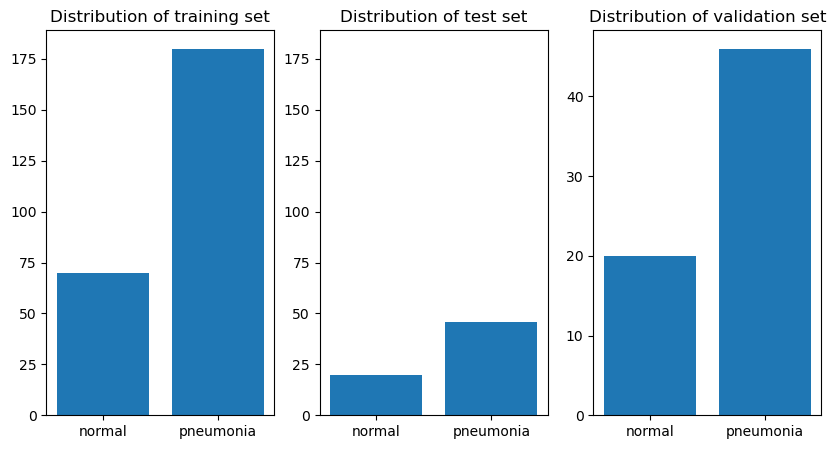

In [7]:
# plot distribution of each data set
labels = ["normal", "pneumonia"]
labels_num = [0,1]
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))

# Bar for training
pneumonia = np.count_nonzero(traindata.targets)
normal = len(traindata.targets) - pneumonia
ax1.bar(labels_num, [normal,pneumonia])
ax1.set_xticks(labels_num, labels)
ax1.set_title("Distribution of training set")
ylim = ax1.get_ylim()

# Bar for testing
pneumonia = np.count_nonzero(testdata.targets)
normal = len(testdata.targets) - pneumonia
ax2.bar(labels_num, [normal,pneumonia])
ax2.set_xticks(labels_num, labels)
ax2.set_title("Distribution of test set")
ax2.set_ylim(ylim)

# Bar for validation
pneumonia = np.count_nonzero(testdata.targets)
normal = len(testdata.targets) - pneumonia
ax3.bar(labels_num, [normal,pneumonia])
ax3.set_xticks(labels_num, labels)
ax3.set_title("Distribution of validation set")
#ax2.set_ylim(ylim)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


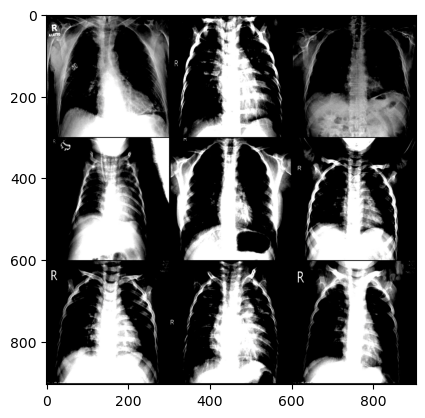

In [8]:
examples = next(iter(trainloader))
images, labels = examples
grid = make_grid(images[:9], nrow=3)
plt.imshow(grid.permute(1, 2, 0))

In [9]:
# Defining our model
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25),

            nn.Flatten(),
            nn.Linear(in_features=350464, out_features=1024),
            nn.LeakyReLU(0.02),
            nn.BatchNorm1d(num_features=1024),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.LeakyReLU(0.02),
            nn.BatchNorm1d(num_features=512),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=2),
            #nn.Softmax()
        )

    def forward(self, x):
        return self.convlayer(x)

In [10]:
# Training
training_writer = SummaryWriter(log_dir=f"runs2/DeepCNN_lr_{lr}_big_batches")
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
best_val_loss = float('inf')
 

for epoch in range(epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        model.train()
        output = model(images)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_accuracy = 100 * (correct_train / total_train)

    val_loss = 0.0
    correct_val = 0
    total_val = 0
    model.eval()
    with torch.no_grad():
        for batch, (test_images, test_labels) in enumerate(testloader):
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            output = model(test_images)
            loss = criterion(output, test_labels)
            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_val += test_labels.size(0)
            correct_val += (predicted == test_labels).sum().item()
        
    val_loss = val_loss / len(testloader)
    val_accuracy = 100 * (correct_val / total_val)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_DeepCNN.pth")

    training_writer.add_scalar("Train loss", train_loss, epoch)
    training_writer.add_scalar("Train accuracy", train_accuracy, epoch)
    training_writer.add_scalar("Validation loss", val_loss, epoch)
    training_writer.add_scalar("Validation accuracy", val_accuracy, epoch)

    print(f'Epoch: {epoch+1} / {epochs}  | Training loss: {train_loss:.4f} | Train accuracy: {train_accuracy:.4f} | Validation loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}')

Epoch: 1 / 30  | Training loss: 0.6444 | Train accuracy: 70.0000 | Validation loss: 0.5117 | Validation Accuracy: 83.3333
Epoch: 2 / 30  | Training loss: 0.4030 | Train accuracy: 83.2000 | Validation loss: 0.4595 | Validation Accuracy: 84.8485
Epoch: 3 / 30  | Training loss: 0.3523 | Train accuracy: 84.0000 | Validation loss: 0.3650 | Validation Accuracy: 80.3030
Epoch: 4 / 30  | Training loss: 0.3094 | Train accuracy: 88.0000 | Validation loss: 0.3518 | Validation Accuracy: 84.8485
Epoch: 5 / 30  | Training loss: 0.2323 | Train accuracy: 91.6000 | Validation loss: 0.3806 | Validation Accuracy: 83.3333
Epoch: 6 / 30  | Training loss: 0.2120 | Train accuracy: 92.8000 | Validation loss: 0.4076 | Validation Accuracy: 90.9091
Epoch: 7 / 30  | Training loss: 0.1681 | Train accuracy: 92.4000 | Validation loss: 0.3674 | Validation Accuracy: 90.9091
Epoch: 8 / 30  | Training loss: 0.1740 | Train accuracy: 94.4000 | Validation loss: 0.2488 | Validation Accuracy: 90.9091
Epoch: 9 / 30  | Trainin